In [1]:
import numpy as np
import torch
import sklearn
from keras.datasets import cifar10
import tensorflow as tf

In [2]:
class MyModel(torch.nn.Module):
  def __init__(self):

    super(MyModel, self).__init__()

    self.features = torch.nn.Sequential(                                        # Inp: B 3 32 32
        torch.nn.Conv2d(3, 16, 7, stride=1, padding=3),                         # B 16 32 32
        
        #layer 1
        torch.nn.Dropout(0.3),

        torch.nn.Conv2d(16, 16, 3, stride=1, padding=1),                        # B 16 32 32
        torch.nn.BatchNorm2d(16),
        torch.nn.ReLU(),

        torch.nn.Conv2d(16, 16, 3, stride=1, padding=1),                           # B 16 32 32
        torch.nn.BatchNorm2d(16),
        torch.nn.Dropout(0.2),
        torch.nn.ReLU(),

        #layer 2
        torch.nn.Dropout(0.2),

        torch.nn.Conv2d(16, 32, 3, stride=2, padding=1),                        # B 32 16 16
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(),

        torch.nn.Conv2d(32, 32, 3, stride=1, padding=1),                        # B 32 16 16
        torch.nn.BatchNorm2d(32),
        torch.nn.Dropout(0.2),
        torch.nn.ReLU(),
        
        #layer 3
        torch.nn.Dropout(0.2),

        torch.nn.Conv2d(32, 64, 3, stride=2, padding=1),                        # B 64 8 8
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),

        torch.nn.Conv2d(64, 64, 3, stride=1, padding=1),                        # B 64 8 8
        torch.nn.BatchNorm2d(64),
        torch.nn.Dropout(0.5),
        torch.nn.ReLU(),

    )

    self.decider = torch.nn.Sequential(
        torch.nn.Dropout(0.5),
        torch.nn.Linear(8 * 8 * 64, 128), # B 64
        torch.nn.ReLU(),
        torch.nn.Linear(128, 10) # B 10
    )

    self.log_prob_cal = torch.nn.LogSoftmax(dim = -1) # B 10
    self.batch_x_placeholder = torch.zeros(size=[1, 3, 32, 32], dtype=torch.float32, device=torch.device('cuda:0'))
    self.batch_y_placeholder = torch.zeros(size=[1], dtype=torch.long, device=torch.device('cuda:0'))

  def forward(self, b_x, b_y = None):
      conv_features = self.features(b_x)
      class_scores = self.decider(conv_features.flatten(1))
      log_probs = self.log_prob_cal(class_scores)
      loss = -1 * torch.mean(log_probs[torch.arange(b_x.shape[0]), b_y])
      decision = torch.argmax(log_probs, dim = -1)
      return decision, loss
        

In [3]:
from sklearn.datasets import fetch_openml
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train = np.transpose(x_train, axes= (0,3,1,2))
x_train.shape

(50000, 3, 32, 32)

In [5]:
x_test = np.transpose(x_test, axes=(0, 3, 1, 2))
x_test.shape

(10000, 3, 32, 32)

In [6]:
y_train = y_train.reshape((50000,))
y_train.shape

(50000,)

In [7]:
y_test = y_test.reshape((10000,))
y_test.shape

(10000,)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
model = MyModel()
model = model.cuda()

In [10]:
for n, v in model.named_parameters():
  print(n)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.3.weight
features.3.bias
features.5.weight
features.5.bias
features.6.weight
features.6.bias
features.10.weight
features.10.bias
features.11.weight
features.11.bias
features.13.weight
features.13.bias
features.14.weight
features.14.bias
features.18.weight
features.18.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.22.weight
features.22.bias
decider.1.weight
decider.1.bias
decider.3.weight
decider.3.bias


In [11]:
batch_size = 64
batch_x_placeholder = torch.zeros(size= [batch_size, 3, 32, 32], dtype = torch.float32, device=torch.device('cuda:0'))
batch_y_placeholder = torch.zeros(size= [batch_size, 64], dtype = torch.long, device=torch.device('cuda:0'))
epochs = 40

print(batch_x_placeholder.shape)
print(batch_y_placeholder.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64, 64])


In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

train_loss = np.zeros((epochs,))
val_loss = np.zeros((epochs,))
train_acc = np.zeros((epochs,))
val_acc = np.zeros((epochs,))

In [13]:
optimizer = torch.optim.Adam(filter(
    lambda p : p.requires_grad, model.parameters()),
    lr = 0.001
)

In [14]:
from time import time

In [15]:
iters_per_epoch = int(np.ceil(1.0 * len(x_train) / batch_size))

for e in range(epochs):
    t_start = time()

    model.train() # training phase

    # shuffling
    inds = np.arange(len(x_train))
    np.random.shuffle(inds)

    epoch_loss = 0
    true_positive = 0

    # iterating over the whole training set
    for iter in range(iters_per_epoch):

        batch_inds = inds[iter * batch_size: min(len(inds), (iter + 1) * batch_size)]

        # reshaping placeholders
        if len(x_train[batch_inds, :, :, :]) != len(batch_x_placeholder):
            batch_x_placeholder.resize_([len(batch_inds), 3, 32, 32])
            batch_y_placeholder.resize_([len(batch_inds)])

        batch_x_placeholder.copy_(torch.Tensor(x_train[batch_inds, :, :, :]))
        
        if y_train[batch_inds] is not None:
            batch_y_placeholder.copy_(torch.Tensor(y_train[batch_inds].astype(int)))

        b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)

        if y_train[batch_inds] is None:
            b_decision = model(batch_x_placeholder, batch_y_placeholder)
        
        else:
            b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
        
        b_decision = b_decision.cpu().numpy()
      
        epoch_loss += float(b_loss) / iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
        true_positive += np.sum(y_train[batch_inds].astype(int) == b_decision)

        b_loss.backward() # calculates derivations

        optimizer.step()
        optimizer.zero_grad() # CARE: MUST DO

    epoch_train_accuracy = true_positive * 100.0 / len(x_train)
    train_loss[e] = epoch_loss
    train_acc[e] = epoch_train_accuracy

    
 # Validating over validation data
    with torch.no_grad():
        model.eval()  # validation phase

        val_inds = np.arange(len(x_val))

        val_iters_per_epoch = int(np.ceil(1.0 * len(x_val) / batch_size))

        predicts = []
        epoch_validation_loss = 0
        val_true_positive = 0


        # iterating over the whole training set
        for iter in range(val_iters_per_epoch):

            val_batch_inds = val_inds[iter * batch_size: min(len(val_inds), (iter + 1) * batch_size)]

            # reshaping placeholders
            if len(val_batch_inds) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(val_batch_inds), 3, 32, 32])
                batch_y_placeholder.resize_([len(val_batch_inds)])

            batch_x_placeholder.copy_(torch.Tensor(x_val[val_batch_inds, :, :, :]))
            batch_y_placeholder.copy_(torch.Tensor(y_val[val_batch_inds].astype(int)))

            if y_val[val_batch_inds] is not None:
                batch_y_placeholder.copy_(torch.Tensor(y_val[val_batch_inds].astype(int)))

            b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)

            if y_val[val_batch_inds] is None:
                b_decision = model(batch_x_placeholder, batch_y_placeholder)
            
            else:
                b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
        
            b_decision = b_decision.cpu().numpy()
        
            if y_val is not None:
                
                epoch_validation_loss += float(b_loss) / val_iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
                val_true_positive += np.sum(y_val[val_batch_inds].astype(int) == b_decision)
            else:
                predicts.append(b_decision)
                

        if y_val is not None:
                epoch_validation_accuracy = val_true_positive * 100.0 / len(x_val)
                val_loss[e] = epoch_validation_loss
                val_acc[e] = epoch_validation_accuracy
            
        else:
            epoch_val_loss, epoch_val_accuracy = np.concatenate(predictions)


        # TO Complete
    
    print(f'Train epoch Loss: {epoch_loss:.4f}, train accuracy: {epoch_train_accuracy:.2f}, Validation Loss: {epoch_validation_loss:.4f}, validation accuracy: {epoch_validation_accuracy:.2f}')

    # Saving the model and optimizer state
    torch.save({
            'epoch': e,
            'optimizer_state_dict': optimizer.state_dict(),
            'model_state_dict': model.state_dict(),
            'train_loss': epoch_loss,
            'train_accuracy': epoch_train_accuracy,
            'validation_loss': epoch_validation_loss,
            'validation_accuracy': epoch_validation_accuracy
        }, 'epoch_%d_state.pt' % e)

    print('Epoch %d ended in %.2f secs.' % (e, time() - t_start,))



Train epoch Loss: 1.6997, train accuracy: 37.21, Validation Loss: 1.4121, validation accuracy: 48.17
Epoch 0 ended in 6.83 secs.
Train epoch Loss: 1.3993, train accuracy: 48.77, Validation Loss: 1.2244, validation accuracy: 56.11
Epoch 1 ended in 6.67 secs.
Train epoch Loss: 1.2640, train accuracy: 54.34, Validation Loss: 1.0965, validation accuracy: 60.24
Epoch 2 ended in 6.66 secs.
Train epoch Loss: 1.1521, train accuracy: 58.60, Validation Loss: 1.0224, validation accuracy: 63.37
Epoch 3 ended in 6.69 secs.
Train epoch Loss: 1.0725, train accuracy: 61.81, Validation Loss: 0.9421, validation accuracy: 66.29
Epoch 4 ended in 6.67 secs.
Train epoch Loss: 1.0087, train accuracy: 64.25, Validation Loss: 0.9017, validation accuracy: 68.08
Epoch 5 ended in 6.69 secs.
Train epoch Loss: 0.9647, train accuracy: 65.55, Validation Loss: 0.8897, validation accuracy: 68.78
Epoch 6 ended in 6.68 secs.
Train epoch Loss: 0.9234, train accuracy: 67.12, Validation Loss: 0.8627, validation accuracy: 69

In [16]:
import matplotlib.pyplot as plt

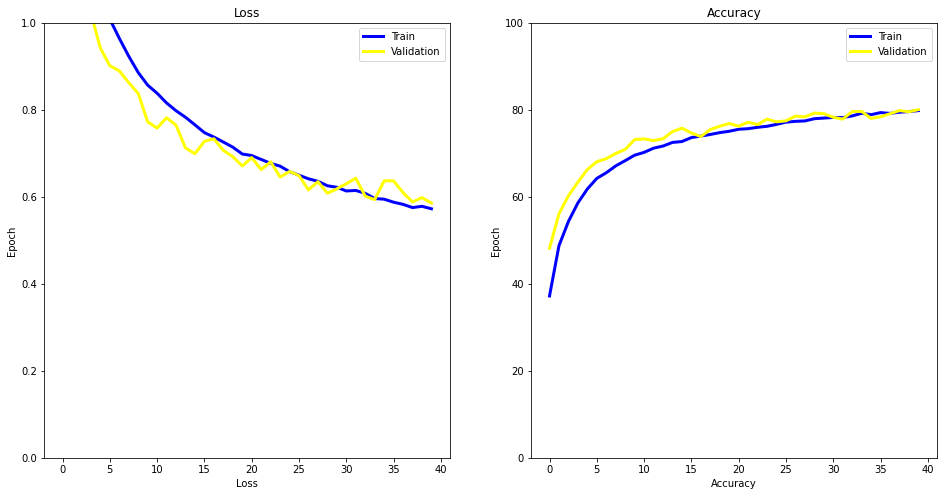

In [17]:
fig = plt.figure(figsize=(16, 8))


# loss
ax = fig.add_subplot(121)
ax.set_title('Loss')
ax.set_xlabel('Loss')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='blue', linewidth=3)
plt.plot(val_loss, label='Validation', color='yellow', linewidth=3)
plt.ylim(0, 1)

plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')
plt.ylim((0, 100))

plt.plot(train_acc, label='Train', color='blue', linewidth=3)
plt.plot(val_acc, label='Validation', color='yellow', linewidth=3)


plt.legend()

In [18]:
with torch.no_grad():
        model.eval()  # validation phase

        val_inds = np.arange(len(x_test))

        val_iters_per_epoch = int(np.ceil(1.0 * len(x_test) / batch_size))

        epoch_validation_loss = 0
        val_true_positive = 0
        predictions = []

        # iterating over the whole training set
        for iter in range(val_iters_per_epoch):

            val_batch_inds = val_inds[iter * batch_size: min(len(val_inds), (iter + 1) * batch_size)]

            # reshaping placeholders
            if len(val_batch_inds) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(val_batch_inds), 3, 32, 32])
                batch_y_placeholder.resize_([len(val_batch_inds)])

            batch_x_placeholder.copy_(torch.Tensor(x_test[val_batch_inds, :, :, :]))
            batch_y_placeholder.copy_(torch.Tensor(y_test[val_batch_inds].astype(int)))

            b_decision, b_loss = model(batch_x_placeholder, batch_y_placeholder)
            b_decision = b_decision.cpu().numpy()

            predictions.append(b_decision)
        
            epoch_validation_loss += float(b_loss) / val_iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
            val_true_positive += np.sum(y_test[val_batch_inds].astype(int) == b_decision)
                
        epoch_validation_accuracy = val_true_positive * 100.0 / len(x_test)
        val_loss = epoch_validation_loss
        val_acc = epoch_validation_accuracy


print('Test Loss %.4f , Accuracy: %.2f' % (val_loss, val_acc))

Test Loss 0.5762 , Accuracy: 80.14


In [19]:
y_test = y_test.astype(int)
predictions = np.concatenate(predictions)

there are 8014 correct predictions. We have chosen a few of them randomly.


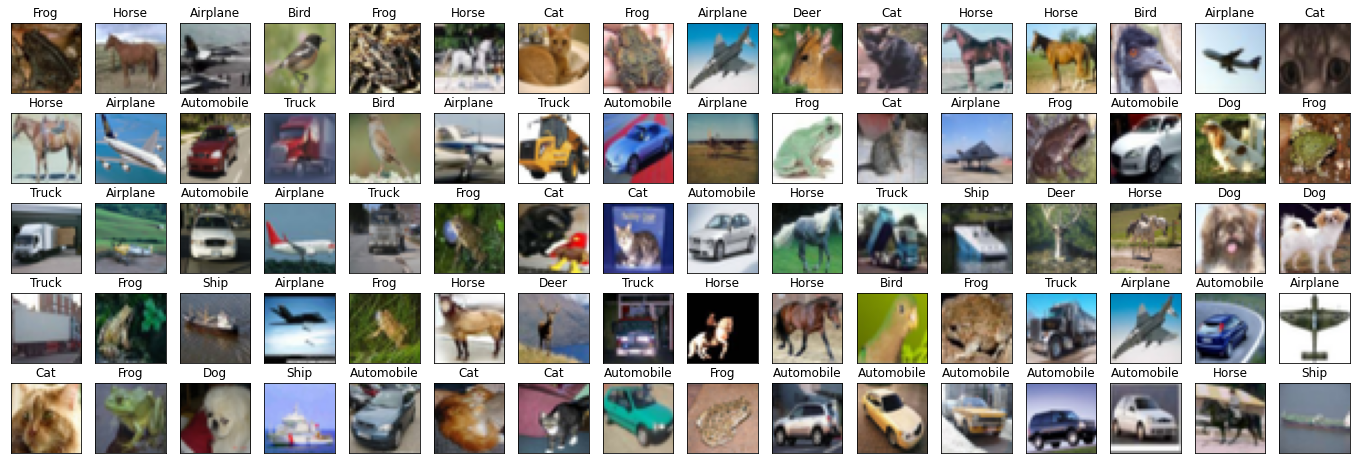

In [20]:
right_images = x_test[predictions == y_test]
print('there are %d correct predictions. We have chosen a few of them randomly.' % len(right_images))
right_labels = predictions[predictions == y_test]
right_indices = np.random.choice(np.arange(len(right_images)), size=80)

images = right_images[right_indices]
label_predictions = right_labels[right_indices]
texts = [f'{label_predictions[i]}' for i in range(len(right_indices))]
columns = 16
rows = 5
final_images = [0] * (columns * rows)

labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

fig = plt.figure(figsize=(1.5 * columns, 1.6 * rows))

for i in range(columns * rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title(labels[int(texts[i])])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(np.transpose(images[i], axes= (1, 2, 0)))

there are 1986 incorrect predictions. We have showed a few of them randomly.


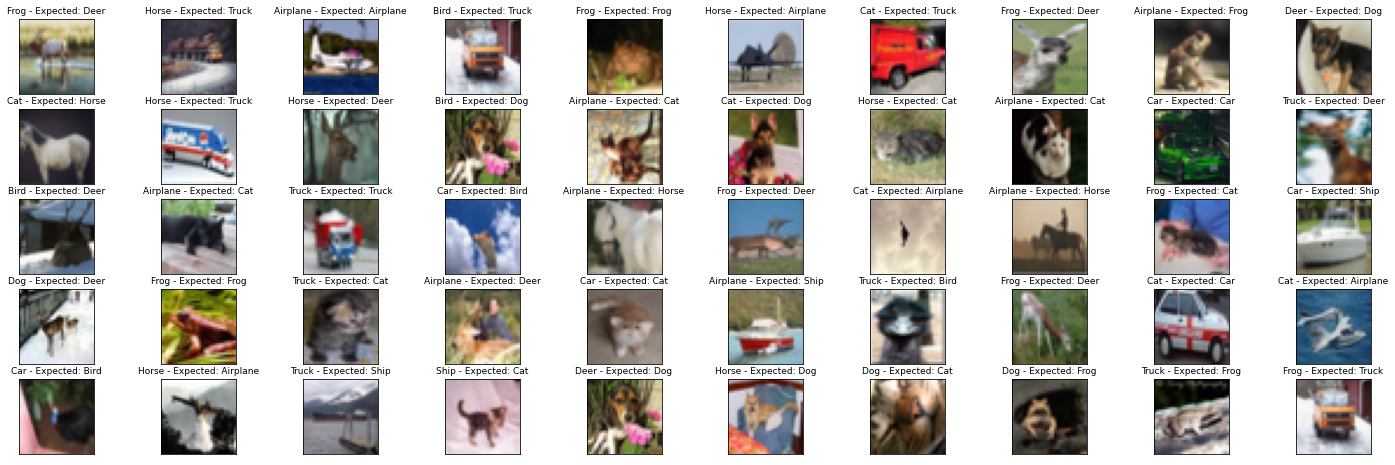

In [21]:
wrong_images = x_test[predictions != y_test]
print('there are %d incorrect predictions. We have showed a few of them randomly.' % len(wrong_images))
wrong_labels = predictions[predictions != y_test]
correct_labels = y_test[predictions != y_test]
wrong_indices = np.random.choice(np.arange(len(wrong_images)), size= 50 )

images = wrong_images[wrong_indices]
wrong_label_predictions = wrong_labels[wrong_indices]
correct_label_predictions = correct_labels[wrong_indices]

texts = [f'{label_predictions[i]}' for i in range(len(wrong_indices))]
columns = 10
rows = 5
final_images = [0] * (columns * rows)

labels = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

fig = plt.figure(figsize=(2.5 * columns, 1.6 * rows))

for i in range(columns * rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    title = f'{labels[int(texts[i])]} - Expected: {labels[int(correct_label_predictions[i])]}'
    ax.set_title(title, fontsize=9)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(np.transpose(images[i], axes= (1, 2, 0)))